In [6]:
import os
import struct
import numpy as np

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [7]:
def read():
    with open('train-labels-idx1-ubyte', 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open('train-images-idx3-ubyte', 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl),rows,cols)
    
    get_img = lambda idx: (lbl[idx], img[idx])
    for i in range(len(lbl)):
        yield get_img(i)

In [8]:
train_data = list(read())

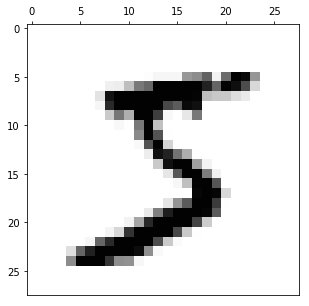

5


In [9]:
label , pixel = train_data[0]
show(pixel)
print(label)

In [10]:
pixel.shape

(28, 28)

In [11]:
img_32= np.pad(pixel,(2,2), 'constant')

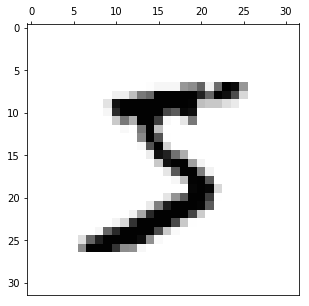

In [12]:
show(img_32)

In [13]:
print("now shape: ",img_32.shape)
img_32_32_1 = img_32.reshape(img_32.shape[0],img_32.shape[0],1)
print("changed shape: ",img_32_32_1.shape)


now shape:  (32, 32)
changed shape:  (32, 32, 1)


IMAGE HAS BEEN RESIZED TO 32X32X1

In [16]:
from PIL import Image
# forward pass for LeNET

FILTER_ROWS = 5    #initialisations
FILTER_COLS = 5
FILTER_DEPTH_LEVEL_1 = 1
FILTER_DEPTH_LEVEL_2 = 6
NUM_FILTERS_LEVEL_1 = 6
NUM_FILTERS_LEVEL_2 = 16

# helper functions
def create_filter(Depth, numFilters, FILTER_ROWS = FILTER_ROWS, FILTER_COLS=FILTER_COLS):
    mat = np.random.randn(FILTER_ROWS,FILTER_COLS ,Depth ,numFilters)
    return mat

def ReLU(X):
        return np.where(X>0,np.where(X<255.0,X,255),0.0)


def do_filter(data, data_filter):
    res = np.multiply(data,data_filter)
    return np.sum(res)

def convolute(this_data, data_filter):
    filtrow, filtcol, depth , numfilt = data_filter.shape
    this_data_row, this_data_col, this_data_width = this_data.shape
    result_dim = this_data_row - filtrow + 1
    result = np.zeros((result_dim, result_dim , numfilt))
    for n in range(numfilt):
        for i in range(result_dim):
            for j in range(result_dim):
                result[i][j][n] = do_filter(this_data[i:i+filtrow, j:j+filtcol , 0:this_data_width] , data_filter[:,:,:,n])
    
    return result

def max_pool(data, stride , pool_rows, pool_cols):
    data_rows , data_cols, data_width = data.shape
    result_rows = int((data_rows - pool_rows)/stride) + 1
    result_cols = int((data_cols - pool_cols)/stride) + 1
    result = np.zeros((result_rows, result_cols , data_width))
    
    for w in range(data_width):
        for i in range(result_rows):
            for j in range(result_cols):
                result[i][j][w] = np.max(data[i*stride:i*stride+pool_rows, j*stride:j*stride+pool_cols , w])
                
    return result
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Neural Network~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Neural Network Layers class
class Layer():
    def __init__(self, num_nodes_prev_layer, num_nodes_this_layer, activation_func):
        self.weights = np.random.randn(num_nodes_prev_layer, num_nodes_this_layer)
        self.bias = np.random.randn(num_nodes_this_layer,1)
        self.activation_func = activation_func
        
        
    def ReLU(X):
        return np.where(X>0,np.where(X<255.0,X,255),0.0)
    
    def sigmoid(self, Z):
        return np.divide(1, np.add(1, np.exp(np.negative(Z))))
    
    def tanh(self, Z):
        return np.tanh(Z)
    
    def softmax(self,z):
        expScores = np.exp(z)
        probs = expScores/np.sum(expScores)
        return probs
    
    def fit(self, data):
        Z = np.add(np.matmul(self.weights.T, data),self.bias)
        if self.activation_func == "RELU":
            self.a = self.ReLU(Z)
        if self.activation_func == "SIGMOID":
            self.a = self.sigmoid(Z)
        if self.activation_func == "TANH":
            self.a = self.tanh(Z)
        if self.activation_func == "SOFTMAX":
            self.a = self.softmax(Z)
            
            
# Neural Network with only forward pass
class NeuralNet():
    def __init__(self):
        self.Layers=[]
    def add_layer(self, num_nodes_prev_layer, num_nodes_this_layer, activation_func):
        self.Layers.append(Layer(num_nodes_prev_layer,num_nodes_this_layer,activation_func))
    def forward_pass(self, data):
        for i in range(len(self.Layers)):
            if i==0:
                self.Layers[i].fit(data)
            else:
                self.Layers[i].fit(self.Layers[i-1].a)

Figures after first layer convolution: C1 maps


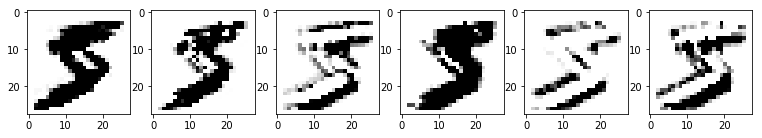

shape after filter level 1: C1 feature maps 
(28, 28, 6)
Figures after first layer max_pooling: S2 f.maps


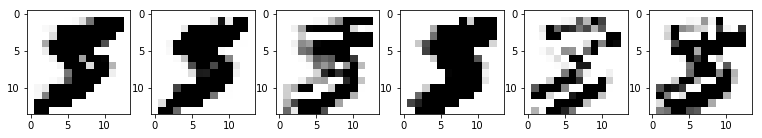

shape after first pooling: S2 f.maps
(14, 14, 6)
Figures after second layer convolution: C3 maps


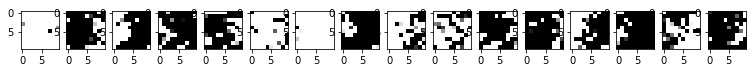

shape after filter level 2: C3 feature maps: 
(10, 10, 16)
Figures after second layer max_pooling:


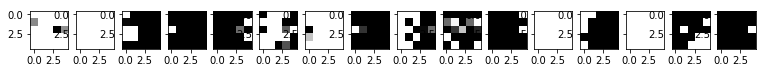

shape after second pooling: s4 f.maps
(5, 5, 16)
Figures after third layer convolution: C5 maps


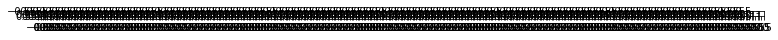

shape after C5 layer :  (1, 1, 120)


In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl

filter_level_1 = create_filter(1,6)
con_result_1 = convolute(img_32_32_1,filter_level_1)
reLURes_1 = ReLU(con_result_1)
print("Figures after first layer convolution: C1 maps")

fig , axes = plt.subplots(1,reLURes_1.shape[2],figsize=(13,13))
for i in range(reLURes_1.shape[2]):
    axes[i].imshow(reLURes_1[:,:,i].astype(int),cmap = mpl.cm.Greys)
plt.show()

print("shape after filter level 1: C1 feature maps ")
print(reLURes_1.shape)
pool_result_1 = max_pool(reLURes_1,2,2,2)
print("Figures after first layer max_pooling: S2 f.maps")
fig , axes = plt.subplots(1,pool_result_1.shape[2],figsize=(13,13))
for i in range(reLURes_1.shape[2]):
    axes[i].imshow(pool_result_1[:,:,i].astype(int), cmap = mpl.cm.Greys)
plt.show()
print("shape after first pooling: S2 f.maps")
print(pool_result_1.shape)
filter_level_2 = create_filter(6,16)
con_result_2 = convolute(pool_result_1,filter_level_2)
reLURes_2 = ReLU(con_result_2)

print("Figures after second layer convolution: C3 maps")
fig , axes = plt.subplots(1,reLURes_2.shape[2],figsize=(13,13))
for i in range(reLURes_2.shape[2]):
    axes[i].imshow(reLURes_2[:,:,i].astype(int), cmap = mpl.cm.Greys)
plt.show()

print("shape after filter level 2: C3 feature maps: ")
print(reLURes_2.shape)
pool_result_2 = max_pool(reLURes_2,2,2,2)




print("Figures after second layer max_pooling:")
fig , axes = plt.subplots(1,pool_result_2.shape[2],figsize=(13,13))
for i in range(pool_result_2.shape[2]):
    axes[i].imshow(pool_result_2[:,:,i].astype(int), cmap = mpl.cm.Greys)
plt.show()


print("shape after second pooling: s4 f.maps")
print(pool_result_2.shape)



filter_level_3 = create_filter(16, 120)
con_result_3 = convolute(pool_result_2, filter_level_3)
reLURes_3 = ReLU(con_result_3)

print("Figures after third layer convolution: C5 maps")
fig , axes = plt.subplots(1,reLURes_3.shape[2],figsize=(13,13))
for i in range(reLURes_3.shape[2]):
    axes[i].imshow(reLURes_3[:,:,i].astype(int), cmap = mpl.cm.Greys)
plt.show()

print("shape after C5 layer : ", reLURes_3.shape)

In [25]:
#flatten the matrix

flatted_data = reLURes_3.flatten()
flatted_data.resize(flatted_data.shape[0],1)
print("shape of flatted data:",flatted_data.shape)
# Neural NetWork forward pass
NN = NeuralNet()
NN.add_layer(flatted_data.shape[0], 84,"TANH") # fully connected hidden layer size 84
NN.add_layer(84,10,"SOFTMAX") # fully connected output layer size 10
NN.forward_pass(flatted_data) #forward pass

shape of flatted data: (120, 1)


In [26]:
print("output of neural network:\n", NN.Layers[1].a)
print("class predicted with random weights:", np.argmax(NN.Layers[1].a))

output of neural network:
 [[1.25311164e-05]
 [3.26546893e-02]
 [9.47152930e-03]
 [2.78863826e-02]
 [1.11067112e-01]
 [8.21372736e-02]
 [7.36645954e-01]
 [3.05584177e-08]
 [1.24497363e-04]
 [1.84206907e-10]]
class predicted with random weights: 6


## QUESTION 2

####  No. of Parameters in first convolution layer
= (filter size)^2 * np of channels in input * no. of filters + np. of filters (no of base)


#### No. of parameters in pooling:
= 0 (only filter dimensions are required)

#### No. of parameters:
Activation function = Pooling layer < Convolution layer < Fully connected layer


#### Memory consumption
convolution layer < Fully connected layers
some cases :
fully connected layer < convolution layers